In [1]:
#pipeline tokenizer->yield fn->vocab->text and label pipelines->dataset->collate fn->
#->dataset and dataloader->LSTM->train and test

In [2]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
from collections import defaultdict

In [3]:
device = torch.device("cuda")

In [4]:
df = pd.read_csv('/kaggle/input/email-spam-classification-dataset/combined_data.csv')

In [5]:
#ignore this part
sampled_df = df.sample(frac=1)

In [6]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>

Index: 12517 entries, 35509 to 40206

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   label   12517 non-null  int64 

 1   text    12517 non-null  object

dtypes: int64(1), object(1)

memory usage: 293.4+ KB


In [7]:
sampled_df['len'] = sampled_df['text'].apply(len)
sampled_df['len'].quantile(0.90)

3379.399999999998

In [8]:
sampled_df['label'].value_counts()

label
1    6579
0    5938
Name: count, dtype: int64

In [9]:
sampled_df.index = range(len(sampled_df))

/Users/aadityajoshi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

  if pd.api.types.is_categorical_dtype(vector):

/Users/aadityajoshi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/Users/aadityajoshi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight

  self._figure.tight_layout(*args, **kwargs)


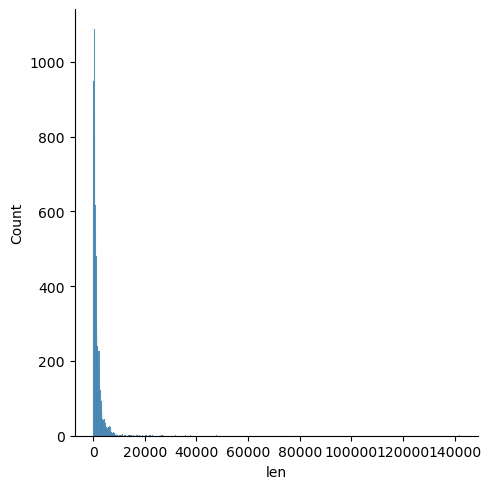

In [10]:
sampled_df['len'] = sampled_df['text'].apply(len)
sns.displot(sampled_df['len'])

In [11]:
sampled_df = sampled_df[sampled_df['len'] <= 2500]

In [12]:
sampled_df.drop('len',axis=1,inplace=True)

In [13]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>

Index: 10517 entries, 0 to 12515

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   label   10517 non-null  int64 

 1   text    10517 non-null  object

dtypes: int64(1), object(1)

memory usage: 246.5+ KB


In [14]:
sampled_df.dropna(inplace=True)
sampled_df.drop_duplicates(inplace=True)
blanks = []
for i,txt,lb in sampled_df.itertuples():
    if type(txt) == str:
        if txt.isspace() == True:
            blanks.append(i)
blanks

[]

In [15]:
#clean text -> lemmatize 
import spacy
nlp = spacy.load('en_core_web_sm')

In [16]:
#function for cleaning the text, first we lowercase the text
#pass it into the spacy object
#then we take lemmatization of text if its not stopword and a punctuation
def clean_lemm(text):
    doc = nlp(text.lower())
    clean_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    return clean_text

In [17]:
sampled_df['text'] = sampled_df['text'].apply(clean_lemm)

In [18]:
sampled_df['text'].head()

0      revno escapenumber revision d tridge samba o...
1    dear code function call u glm u glm function x...
3    hi karina find email date site love sex loving...
4    ex student association university texas bring ...
5    national lottery \n p o box 1010 \n liverpool ...
Name: text, dtype: object

#### get tokenizer and create vocab

In [19]:
def spacy_tokenizer(text):
    # Use the clean_lemm function first
    cleaned_text = clean_lemm(text)
    # Then tokenize the cleaned text
    return cleaned_text.split()

In [23]:
def build_vocab(text_iterator, min_freq=3, specials=('<unk>', '<pad>')):
    token_counts = defaultdict(int)
    for text in text_iterator:
        for token in spacy_tokenizer(text):
            token_counts[token] += 1
    vocab = {token: idx for idx, (token, count) in enumerate(token_counts.items()) if count >= min_freq}
    for special in specials:
        if special not in vocab:
            vocab[special] = len(vocab) 
    return vocab

In [24]:
vocab = build_vocab(sampled_df['text'])

#### create vocab from iterator

In [25]:
vocab_size = len(vocab)
vocab_size

19669

### text and label pipelines

In [26]:
text_pipeline = lambda text: [vocab.get(token, vocab['<unk>']) for token in spacy_tokenizer(text)]
label_pipeline = lambda label: int(label)

In [27]:
#dataset
class EMAIL_Dataset(Dataset):
    def __init__(self,email_df,text_pipeline,label_pipeline):
        self.emails = email_df['text'].tolist()
        self.labels = email_df['label'].tolist()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
    def __len__(self):
        return len(self.emails)
    def __getitem__(self,idx):
        email = self.emails[idx]
        label = self.labels[idx]
        return self.text_pipeline(email),self.label_pipeline(label)
    

In [28]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(sampled_df,test_size=0.2)

In [29]:
train_data = EMAIL_Dataset(train_df,text_pipeline,label_pipeline)
test_data = EMAIL_Dataset(test_df,text_pipeline,label_pipeline)

### pad collate function

In [30]:
def pad_collate(batch):
    text_list = []
    label_list = []
    for text,label in batch:
        label_list.append(label)
        text_list.append(torch.LongTensor(text))
    label_list = torch.LongTensor(label_list)
    text_list = pad_sequence(text_list,batch_first=True)
    return text_list.to(device),label_list.to(device)

In [49]:
train_batch_size = 256
test_batch_size = 256
train_loader = DataLoader(train_data,train_batch_size,shuffle=True,collate_fn=pad_collate)
test_loader = DataLoader(test_data,test_batch_size,shuffle=True,collate_fn=pad_collate)

### BILSTM

In [32]:
class LSTM(nn.Module):
    #contructor method with parent call
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional,p=0.4):
        #parent const call
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        #embedding
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*hidden_size,out_size)
        self.dropout = nn.Dropout(p)
    
    def forward(self,x):
        #prepare hidden and embedding
        hidden = model.init_hidden(x.size(0))
        embedding = self.embedding(x)
        lstm_out,hidden = self.lstm(embedding,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [33]:
model = LSTM(vocab_size,
             embedding_dim=32,hidden_size=16,
             out_size=2,num_layers=2,
             bidirectional=True).to(device)

In [34]:
model

LSTM(
  (embedding): Embedding(19669, 32)
  (lstm): LSTM(32, 16, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [35]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [36]:
import time
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for text,label in train_loader:
        optimizer.zero_grad()
        y_pred = model.forward(text)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
    print(f"epoch : {epoch+1} loss : {loss.item()}")    
print((time.time()-start)/60)

epoch : 1 loss : 0.6237562894821167

epoch : 2 loss : 0.0022558753844350576

epoch : 3 loss : 0.6120662093162537

epoch : 4 loss : 0.007311695721000433

epoch : 5 loss : 0.009533943608403206

11.183624017238618


In [37]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = model(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support



           0       0.97      0.96      0.96       978

           1       0.96      0.97      0.97      1126



    accuracy                           0.97      2104

   macro avg       0.97      0.97      0.97      2104

weighted avg       0.97      0.97      0.97      2104




### GRU

In [42]:
class GRU(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional,p=0.4):
        super(GRU,self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir * hidden_size,out_size)
        
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        embedding = self.embedding(x)
        hidden = self.init_hidden(x.size(0))
        gru_out, hidden = self.gru(embedding, hidden)
        gru_out = self.dropout(gru_out)  # Apply dropout
        pred = self.fc(gru_out[:, -1, :])
        return pred

    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size)).to(device)
        return hidden

In [46]:
GRU_model = GRU(vocab_size,embedding_dim=64,hidden_size=16,out_size=2,num_layers=2,bidirectional=True).to(device)

In [47]:
num_epochs = 5
optimizer = torch.optim.Adam(GRU_model.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [50]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    GRU_model.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = GRU_model(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 263/263 [05:04<00:00,  1.16s/it, loss=0.1014]


Epoch 1/5, Average Loss: 0.1349


Epoch 2/5: 100%|█████████████████| 263/263 [05:00<00:00,  1.14s/it, loss=0.1197]


Epoch 2/5, Average Loss: 0.0548


Epoch 3/5: 100%|█████████████████| 263/263 [04:59<00:00,  1.14s/it, loss=0.0137]


Epoch 3/5, Average Loss: 0.0274


Epoch 4/5: 100%|█████████████████| 263/263 [05:06<00:00,  1.17s/it, loss=0.0009]


Epoch 4/5, Average Loss: 0.0167


Epoch 5/5: 100%|█████████████████| 263/263 [05:00<00:00,  1.14s/it, loss=0.0012]

Epoch 5/5, Average Loss: 0.0173

Total training time: 25.20 minutes


In [51]:
all_preds = []
all_labels = []

GRU_model.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = GRU_model(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support



           0       0.95      0.96      0.95       978

           1       0.96      0.96      0.96      1126



    accuracy                           0.96      2104

   macro avg       0.96      0.96      0.96      2104

weighted avg       0.96      0.96      0.96      2104


